Import all modules we need. 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import scipy 
import scipy.spatial.distance as distance
import sklearn
import sklearn.linear_model as skl_lm
import seaborn as sns
from numpy import shape
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/egg/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The data we used is in Seattle and year is 2012.

In [2]:
fname = "wind_data_2012.csv"
dt = pd.read_csv(fname, error_bad_lines=False)
dt.head()

,Year,Month,Day,Hour,Minute,power (MW),wind direction at 100m (deg),wind speed at 100m (m/s),air temperature at 2m (K),surface air pressure (Pa),density at hub height (kg/m^3)
0,2012,1,1,0,0,0.037,139.827,3.256,278.031,102015.408,1.254
1,2012,1,1,0,5,0.040,142.810,3.289,278.070,102019.072,1.254
2,2012,1,1,0,10,0.049,144.975,3.378,278.095,102022.736,1.254
3,2012,1,1,0,15,0.054,145.431,3.433,278.125,102024.560,1.254
4,2012,1,1,0,20,0.056,144.772,3.457,278.159,102026.400,1.254


In [3]:
power = dt['power (MW)'] #12 months, each month has 8784 data.
speed = dt['wind speed at 100m (m/s)']
print (power.max())
print (power.min())
print (power.shape)
print (speed.shape)

2.0
0.0
(105408,)
(105408,)


In [4]:
power_mean = np.mean(power)
power_std = np.std(power)

print(power_mean)
print(power_std)

0.562147379706
0.671249798216


In [5]:
def PDF(x, mu, sigma):
    pdf = np.exp(-((x - mu)**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    return pdf

PDFx = np.arange(0, 2, .0005) 

power_PDF = PDF(PDFx, power_mean, power_std)
power_PDF.size

speed_PDF = PDF(PDFx, np.mean(speed), np.std(speed))
speed_PDF.size

4000

We calculate the probability distribution of wind speed and power, since the two types of data is most meaningful for further analyse.

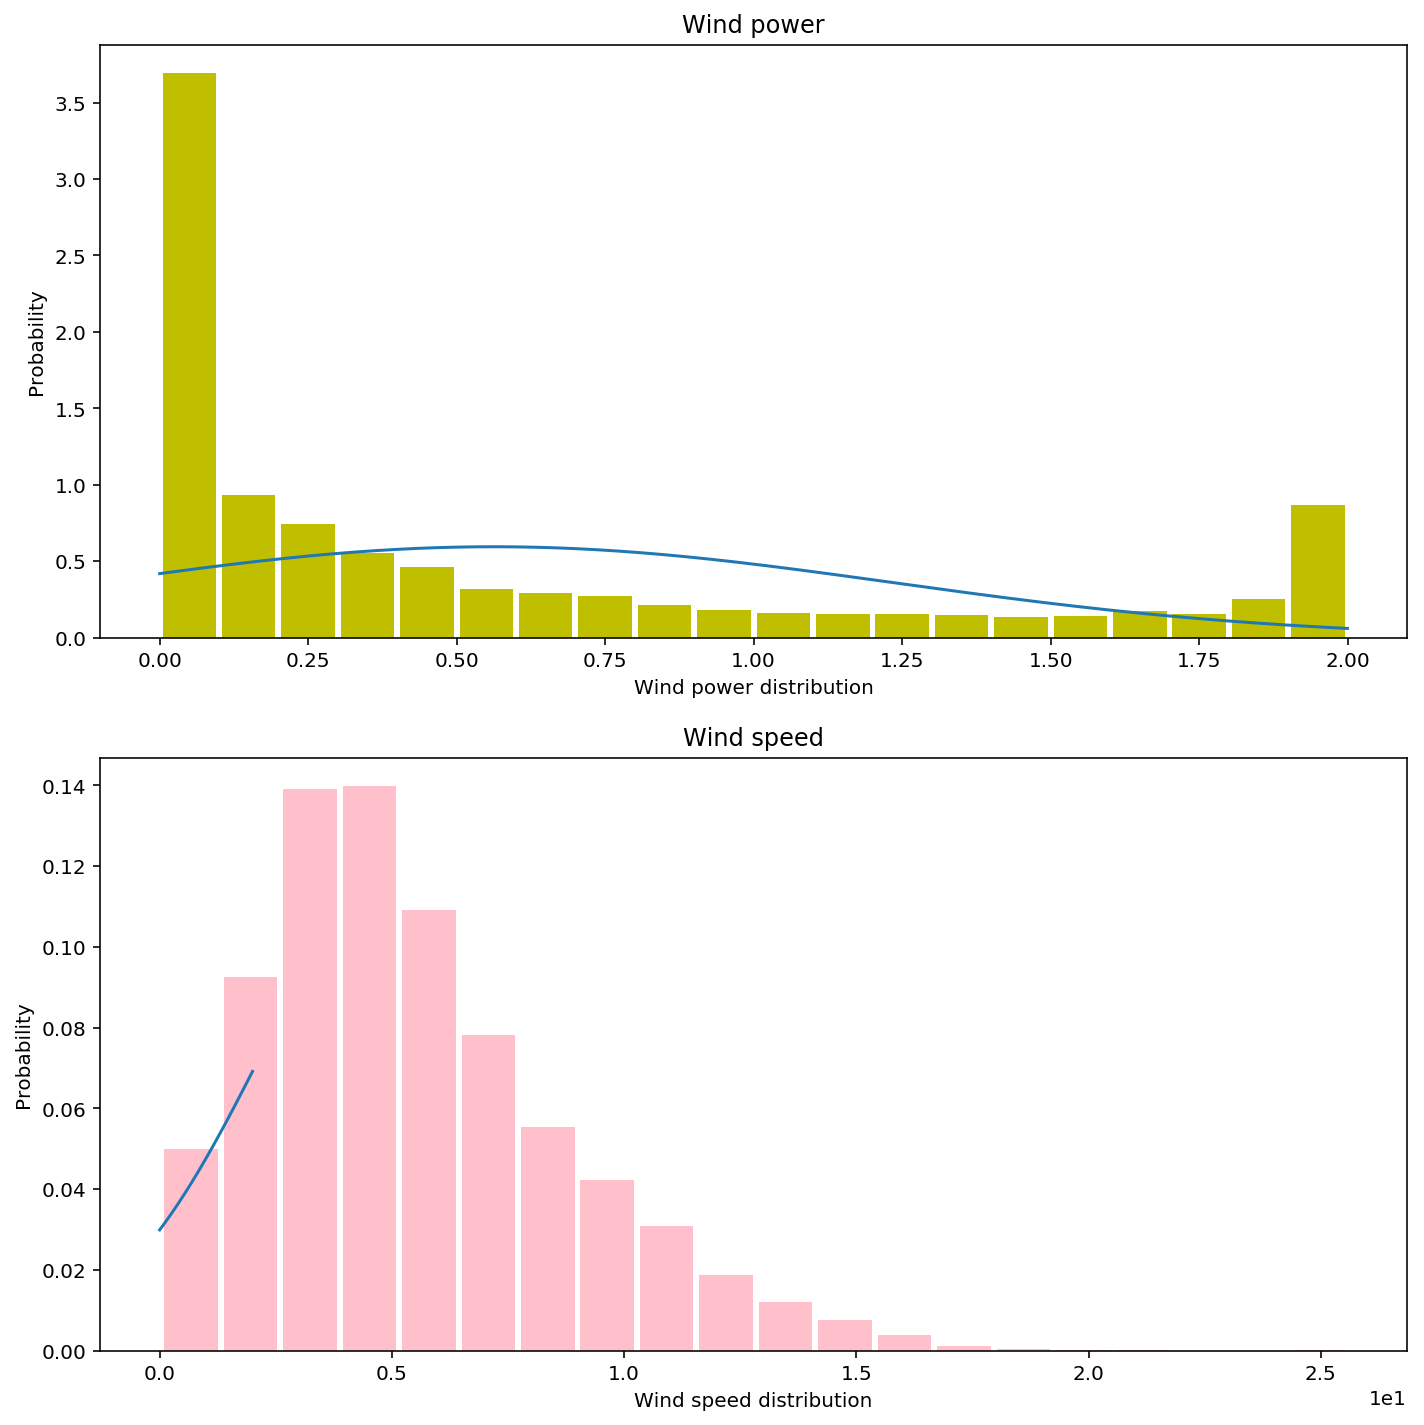

In [6]:
plt.figure(figsize = (10, 10))

plt.subplot(2, 1, 1)
plt.plot(PDFx, power_PDF)
plt.hist(power, normed = True, bins = 20, rwidth = 0.9, color = 'y')
plt.title('Wind power')
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.xlabel('Wind power distribution')
plt.ylabel('Probability')

plt.subplot(2, 1, 2)
plt.plot(PDFx, speed_PDF)
plt.hist(speed, normed = True, bins = 20, rwidth = 0.9, color = 'pink')
plt.title('Wind speed')
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.xlabel('Wind speed distribution')
plt.ylabel('Probability')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.3)
plt.show()

The power data mainly concentrates around 0 (since there are many days without much wind). The speed data mainly concentrates around 5 m/s.

In [7]:
speed_PDF = PDF(PDFx, np.mean(speed), np.std(speed))
speed_PDF.size
plt.show()

In [8]:
def CDF(data, bins):
    hist_data, bin_edges = np.histogram(data, bins = bins, density = True)
    cdf_bins = np.cumsum(hist_data * np.diff(bin_edges))
    return cdf_bins 
CDFx = np.arange(0, 2, .1) 
power_CDF = CDF(power, 20)
print(power_CDF.shape)

(20,)


We also calculate the cumulative distribution function of power (power is the data we want to analyze and make prediction).

[  6.68303481e-08   6.68720320e-08   6.69137047e-08 ...,   9.61590817e-09
   9.60059086e-09   9.58529263e-09]
[  2.67321392e-04   5.34809520e-04   8.02464339e-04 ...,   9.99923256e-01
   9.99961659e-01   1.00000000e+00]


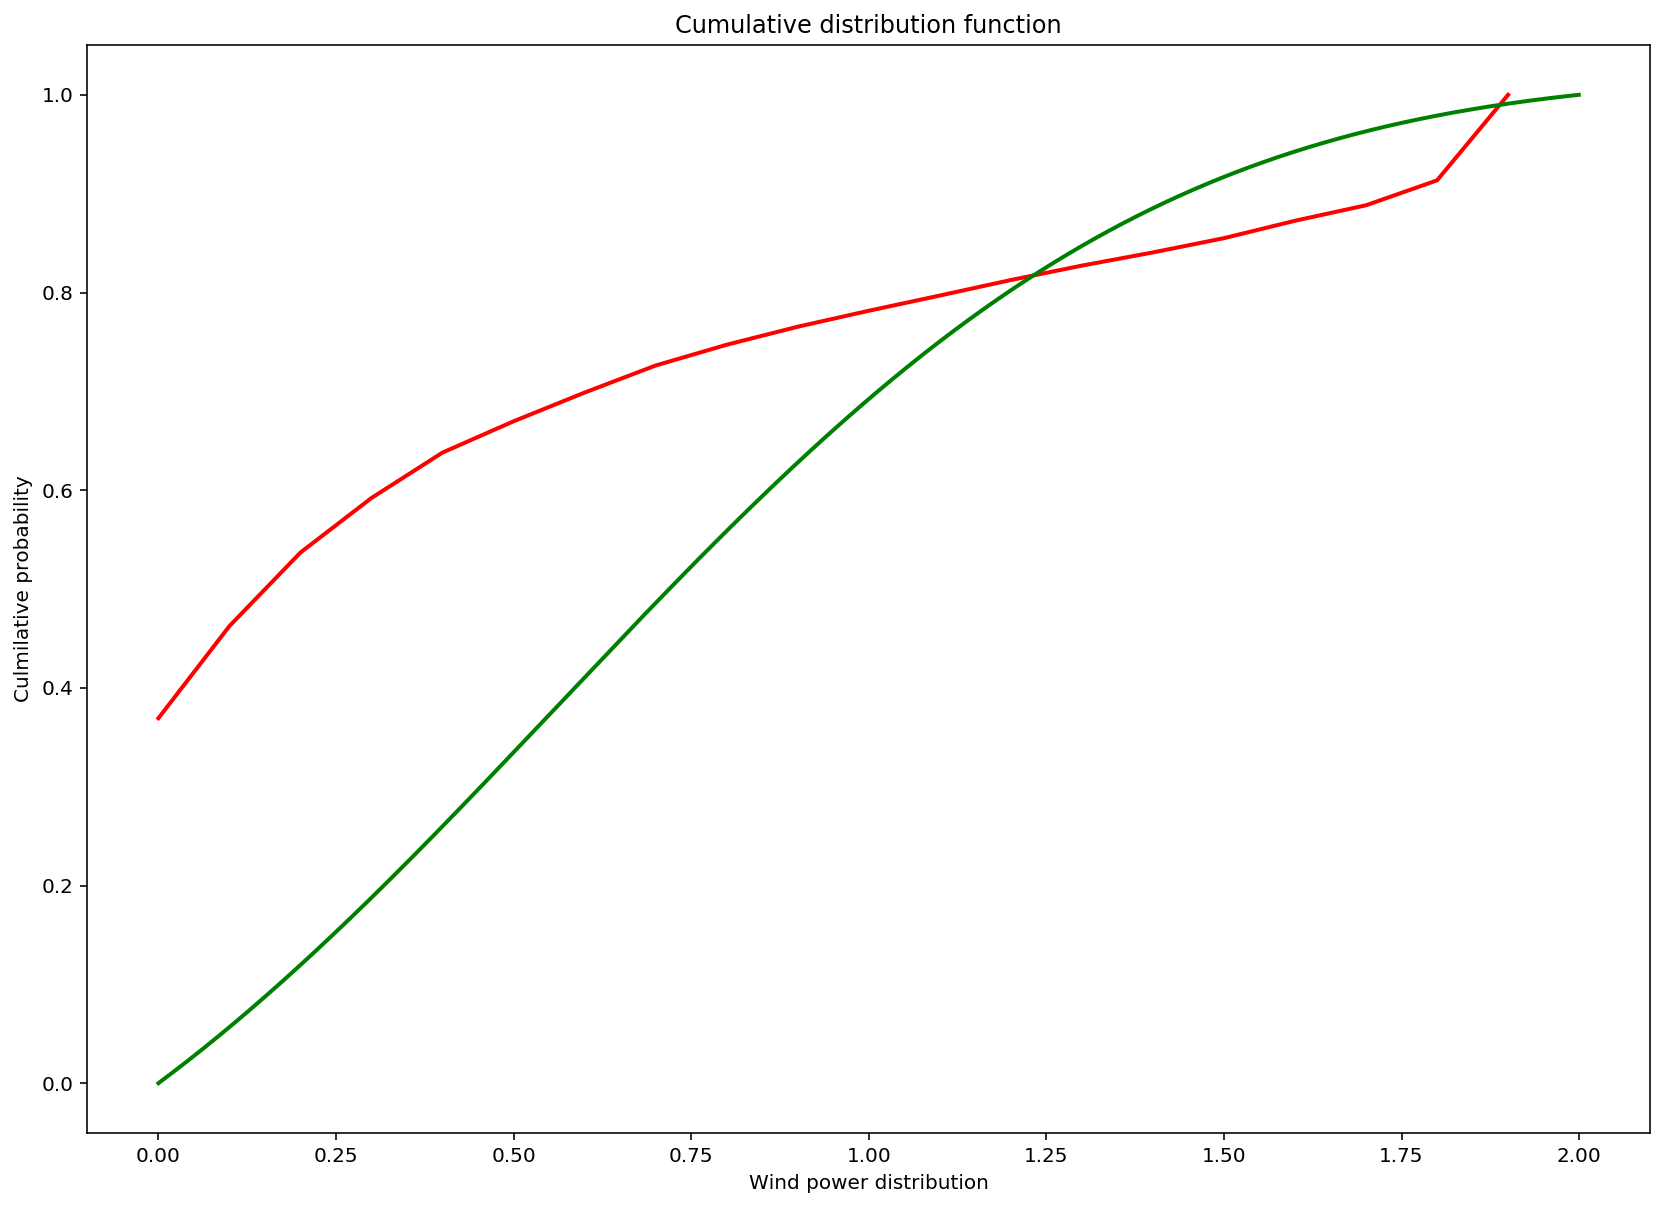

In [9]:
power_dx = 4000
power_X  = np.arange(0, 2, .0005)
power_Y  = power_PDF
# Normalize the data to a proper PDF
power_Y /= (power_dx * power_Y).sum()
# Compute the CDF
cdf = np.cumsum(power_Y * power_dx)
print(power_Y)
print(cdf)

plt.figure(figsize = (14, 10))
plt.plot(CDFx, power_CDF, color = 'red', lw=2)
plt.plot(PDFx, cdf, color = 'green', lw=2)
plt.title('Cumulative distribution function')
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.xlabel('Wind power distribution')
plt.ylabel('Culmilative probability')
plt.show()

We see the actual 'CDF' is much different from the normed 'CDF'. Which means we can not use a simple statistics model to analyze our data.

In [59]:
list_throw = []
speed_1 = []
power_1 = []
direction = []
temp = []
time = []
dense = []
press = []
for i in range(len(power)):
    if dt.loc[i]["wind speed at 100m (m/s)"] > 15 and dt.loc[i]["power (MW)"] < 0.25:
        list_throw.append(i)
    else:
        speed_1.append(speed[i])
        power_1.append(power[i])
        direction.append(dt.loc[i]["wind direction at 100m (deg)"])
        temp.append(dt.loc[i]["air temperature at 2m (K)"])
        dense.append(dt.loc[i]["density at hub height (kg/m^3)"])
        press.append(dt.loc[i]["surface air pressure (Pa)"])
    time.append(i)

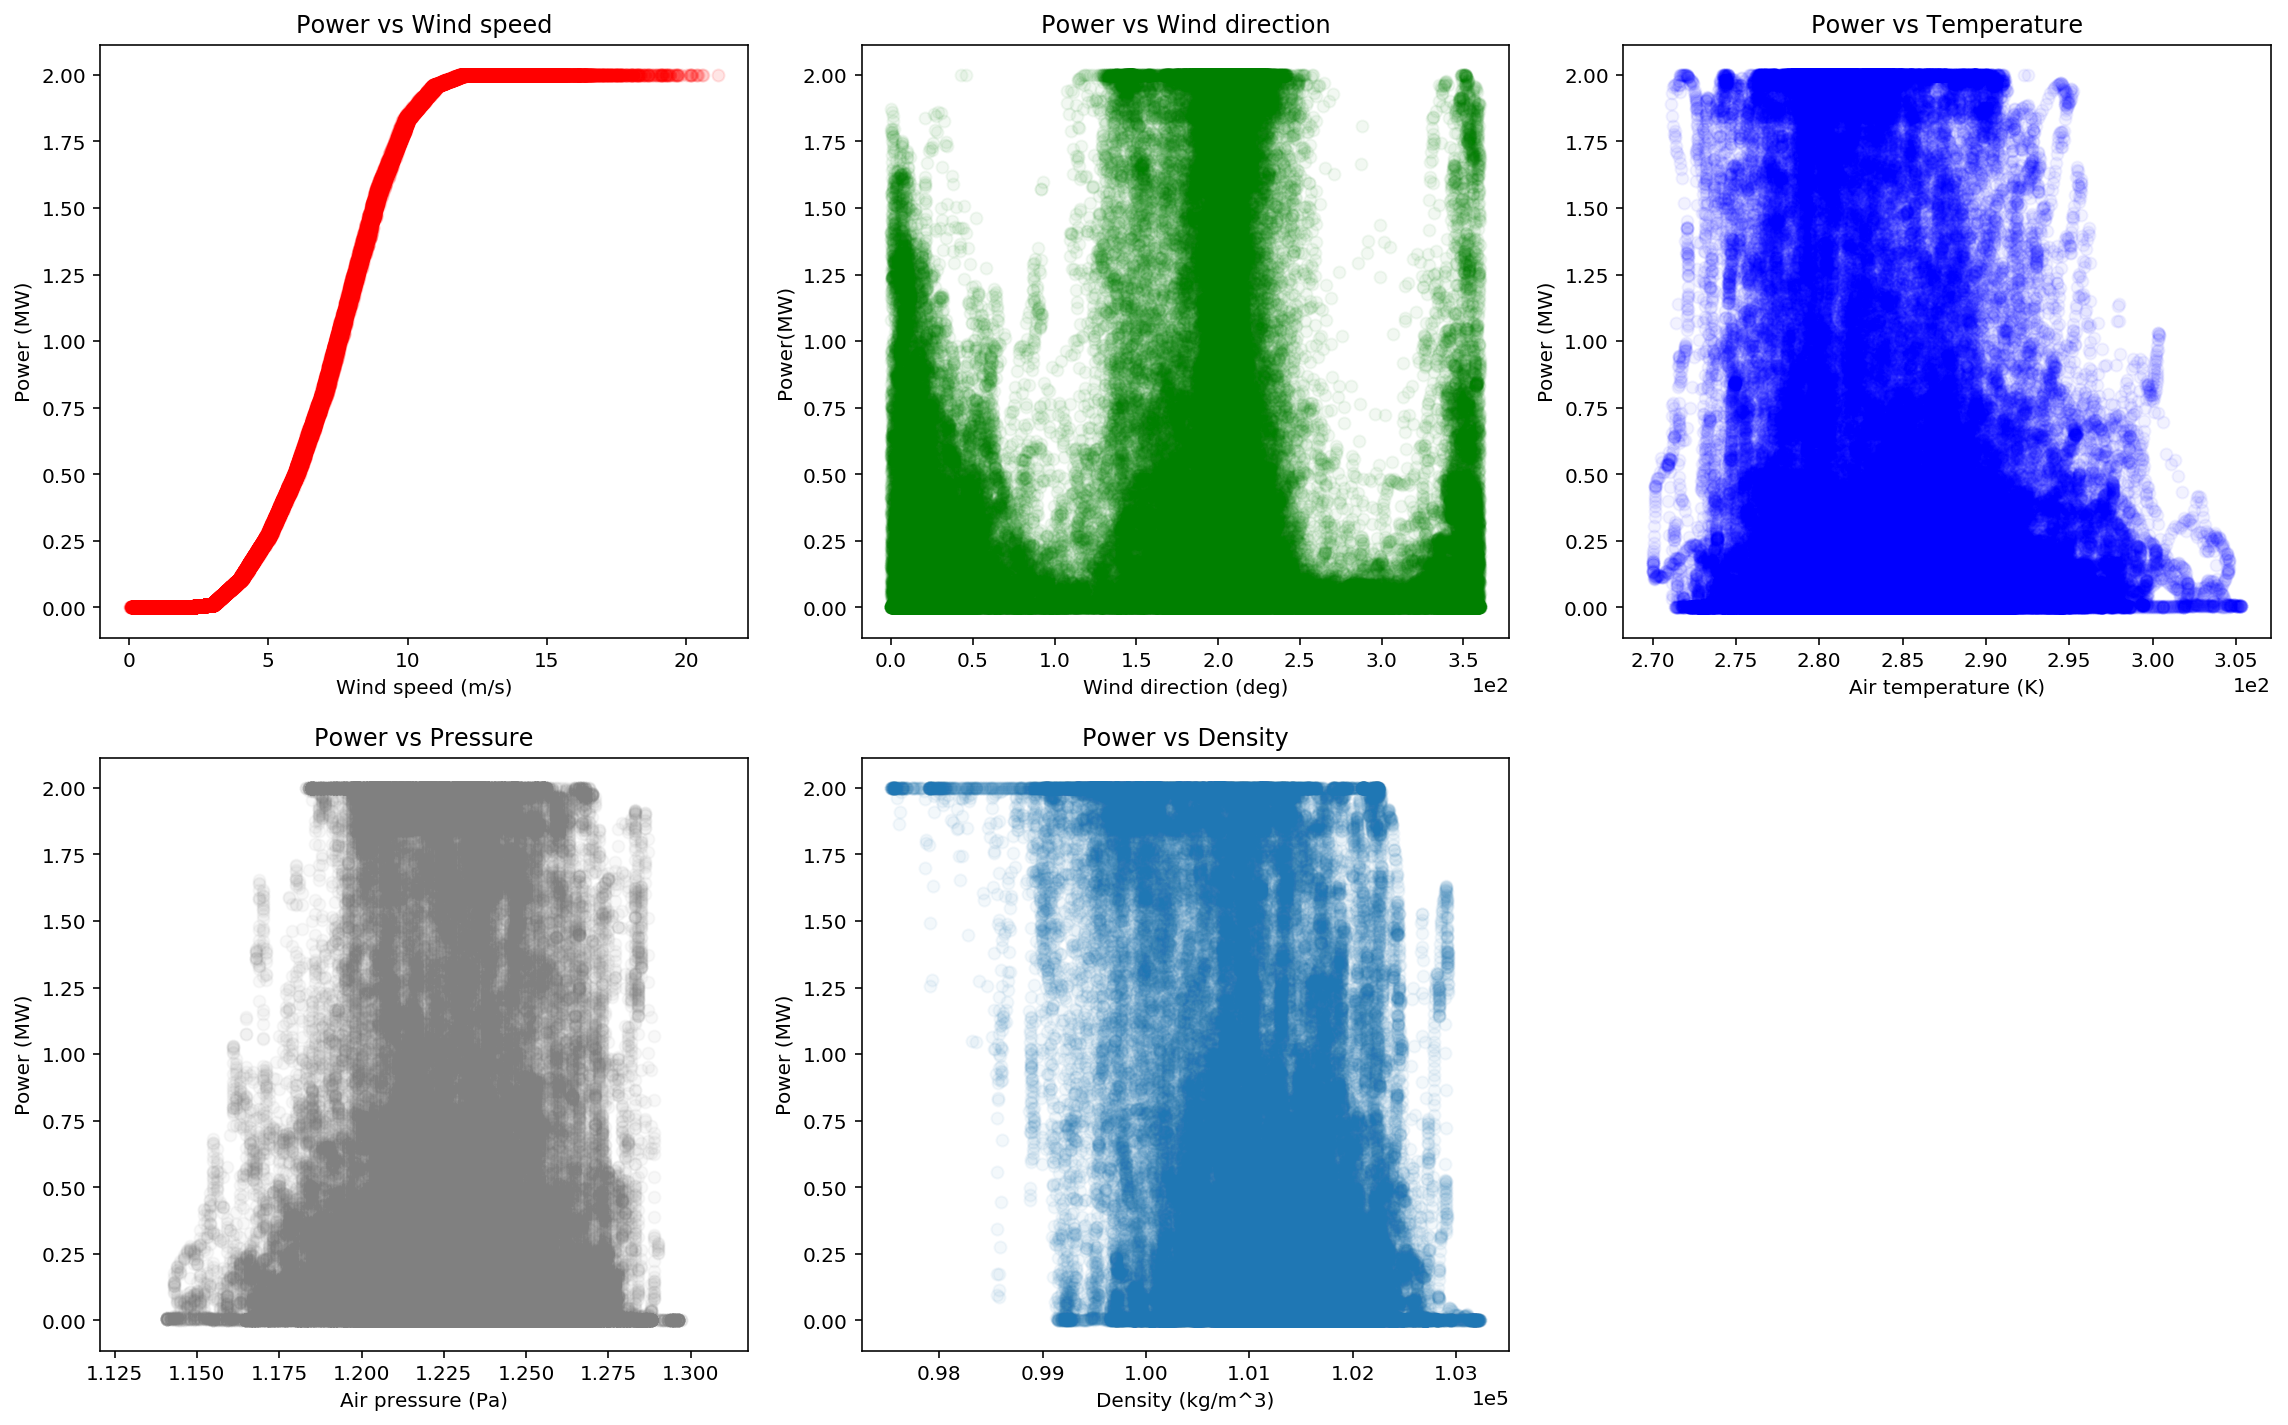

In [60]:
plt.figure(figsize = (16, 10))
plt.subplot(2, 3, 1)
plt.scatter(speed_1, power_1, color='r', alpha=.1)
plt.title('Power vs Wind speed')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')

plt.subplot(2, 3, 2)
plt.scatter(direction, power_1, color='g', alpha=.05)
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.title('Power vs Wind direction')
plt.xlabel('Wind direction (deg)')
plt.ylabel('Power(MW)')

plt.subplot(2, 3, 3)
plt.scatter(temp, power_1, color='b', alpha=.05)
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.title('Power vs Temperature')
plt.xlabel('Air temperature (K)')
plt.ylabel('Power (MW)')

plt.subplot(2, 3, 4)
plt.scatter(dense, power_1, color='gray', alpha=.05)
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.title('Power vs Pressure')
plt.xlabel('Air pressure (Pa)')
plt.ylabel('Power (MW)')

plt.subplot(2, 3, 5)
plt.scatter(press, power_1, alpha=.05)
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.title('Power vs Density')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Power (MW)')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.3)
plt.show()

In [24]:
import scipy.stats as stats

print(stats.ttest_1samp(dt['power (MW)'], power_mean))
print(stats.ttest_1samp(dt['wind speed at 100m (m/s)'], np.mean(speed)))

Ttest_1sampResult(statistic=0.0, pvalue=1.0)
Ttest_1sampResult(statistic=0.0, pvalue=1.0)


In [26]:
month = np.reshape(time, (-1, 8784))
power_month = power.reshape(-1, 8784)
speed_month = speed.reshape(-1, 8784)
power_month[0]

array([ 0.037,  0.04 ,  0.049, ...,  0.949,  1.079,  1.138])

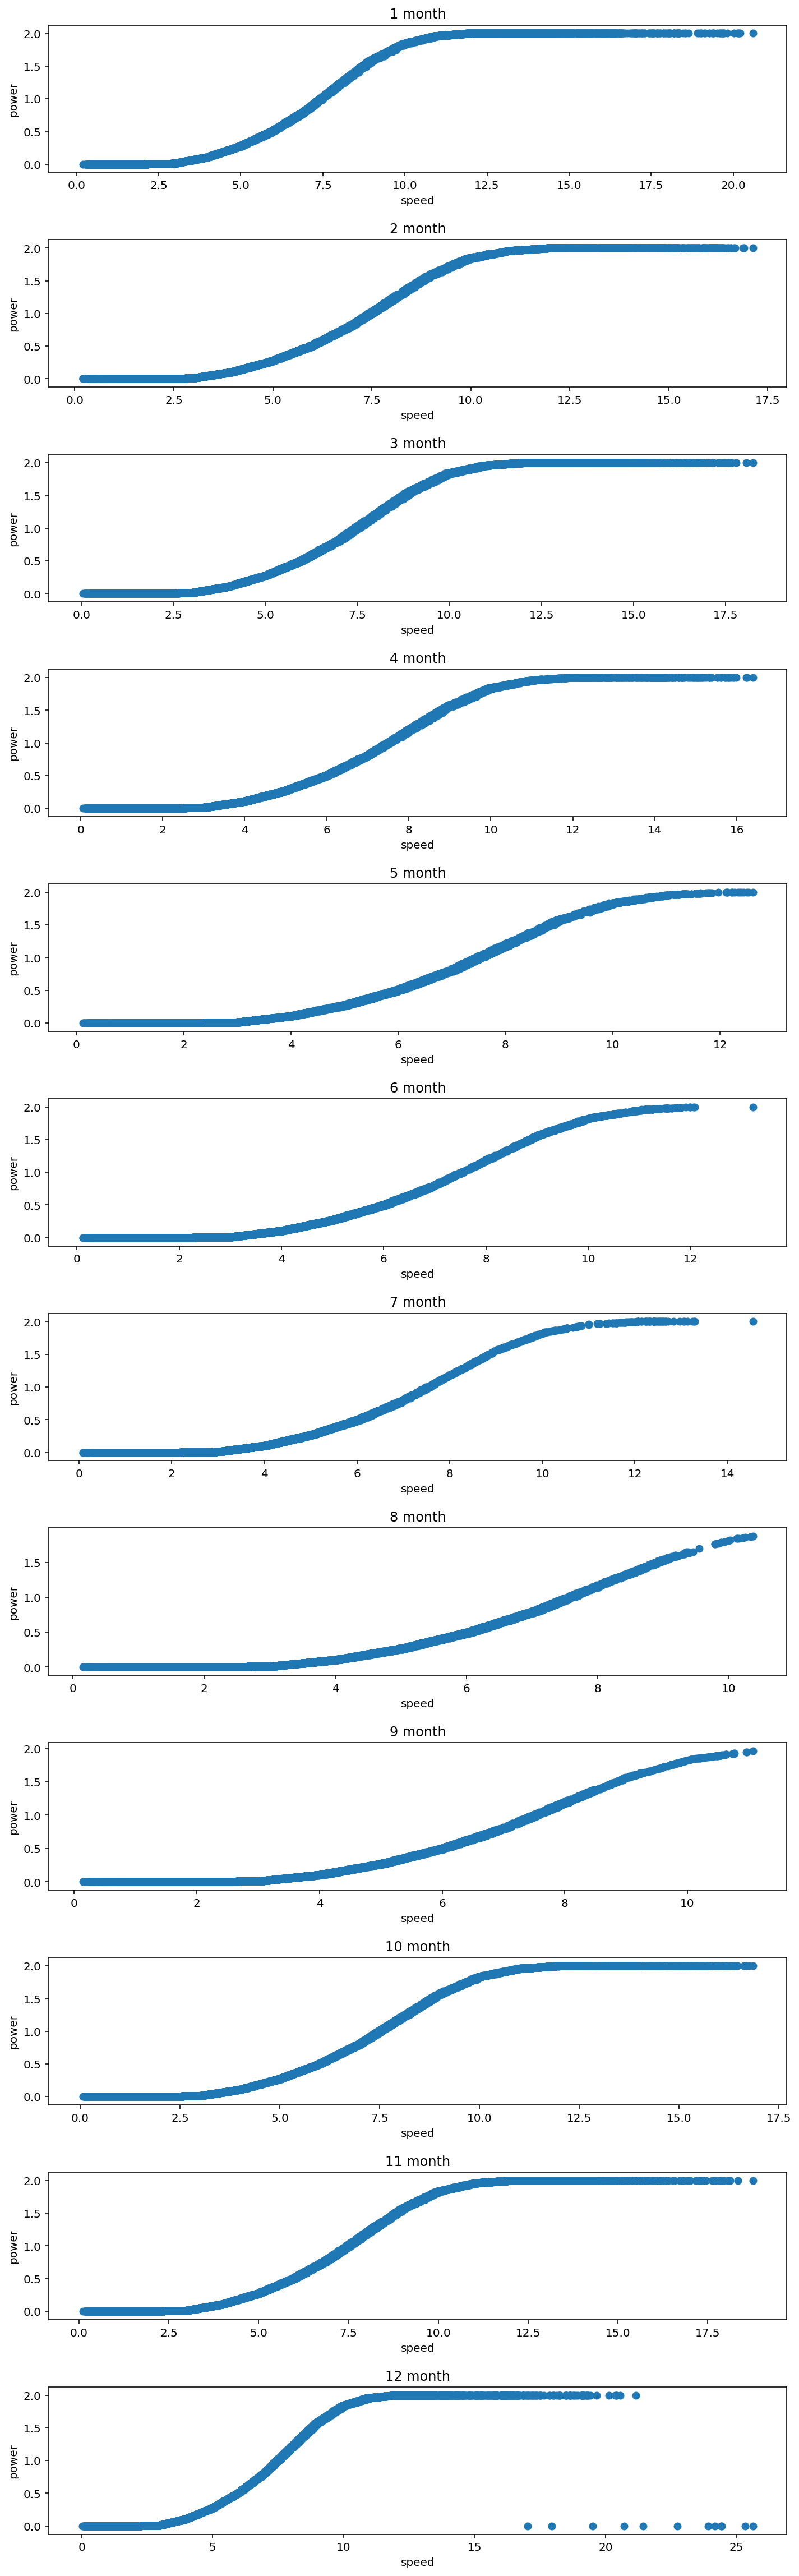

In [34]:
plt.figure(figsize = (10, 32))
for i in range(12):
    plt.subplot(12, 1, i + 1)
    plt.scatter(speed_month[i], power_month[i])
    plt.title(str(i + 1) + " month")
    plt.xlabel('speed')
    plt.ylabel('power')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.3)
plt.show()

Plot the scatter plot of power and speed in each month.

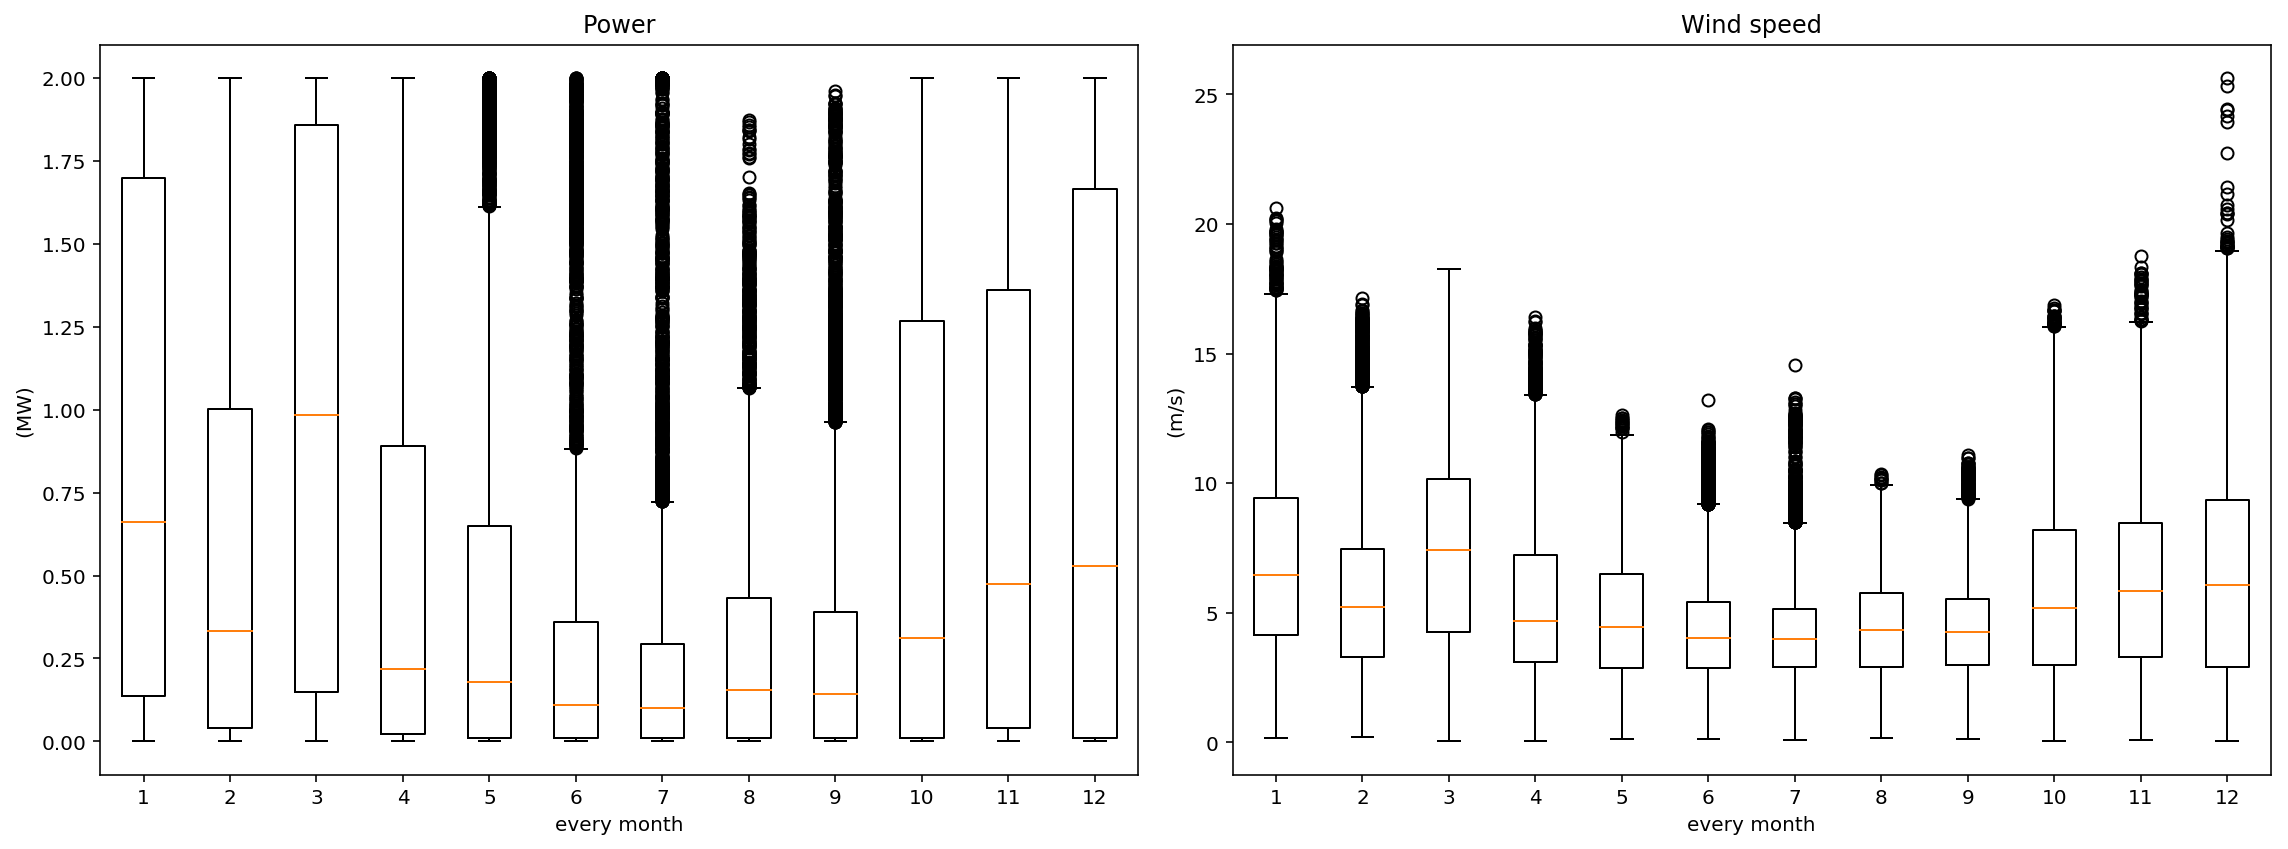

In [12]:
box_power=[]
box_speed=[]
for i in range(12):
    box_power.append(power_month[i])
    box_speed.append(speed_month[i])
    
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.boxplot(box_power, meanline = True)
plt.title('Power')
plt.xlabel('every month')
plt.ylabel('(MW)')

plt.subplot(1, 2, 2)
plt.boxplot(box_speed, meanline = True)
plt.title('Wind speed')
plt.xlabel('every month')
plt.ylabel('(m/s)')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.3)
plt.show()

We prepare the boxplot data of power and wind of each month. To some degree this plot show the power and speed distribution of whole year. 

In order to analyze power data, we use power value with other data to plot the figure. As we can see the power value is more related with wind speed. So here, we want to figure out the relationship between power and speed.

In [14]:
corr_list = []
for i in range(12):
    df_month = pd.DataFrame([speed_month[i], power_month[i]])
    for j in range(72):
        # every 122 data, calculate correlation coefficient
        corr_list.append(df_month.loc[0][j*122 : (j+1)*122].corr(df_month.loc[1][j*122 : (j+1)*122]))
corr_list = np.array(corr_list).reshape(-1,1)
corr_list1 = corr_list[np.logical_not(np.isnan(corr_list))]
x_corr = np.arange(0, len(corr_list1), 1).reshape(-1,1)
print(len(x_corr))
corr_list1 = np.array(corr_list1).reshape(-1,1)

850


We select each 122 data (which means around each 10 hr) to calculate the correlation coefficient between power and wind. We see the coefficient is mainly concentrates on '0.8 ~ 1.0'.

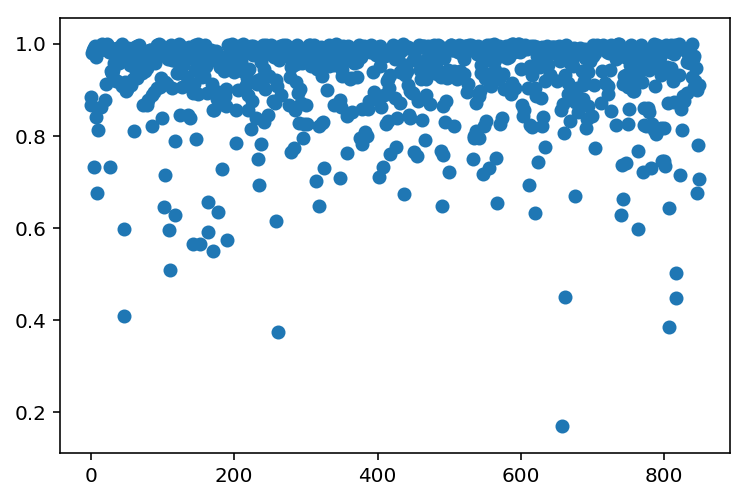

In [15]:
plt.scatter(x_corr, corr_list1)

[  1.02882858e-18   1.07770766e-18   1.12888054e-18 ...,   1.80798371e-25
   1.71255891e-25   1.62212974e-25]


[0, 1, 0, 15]

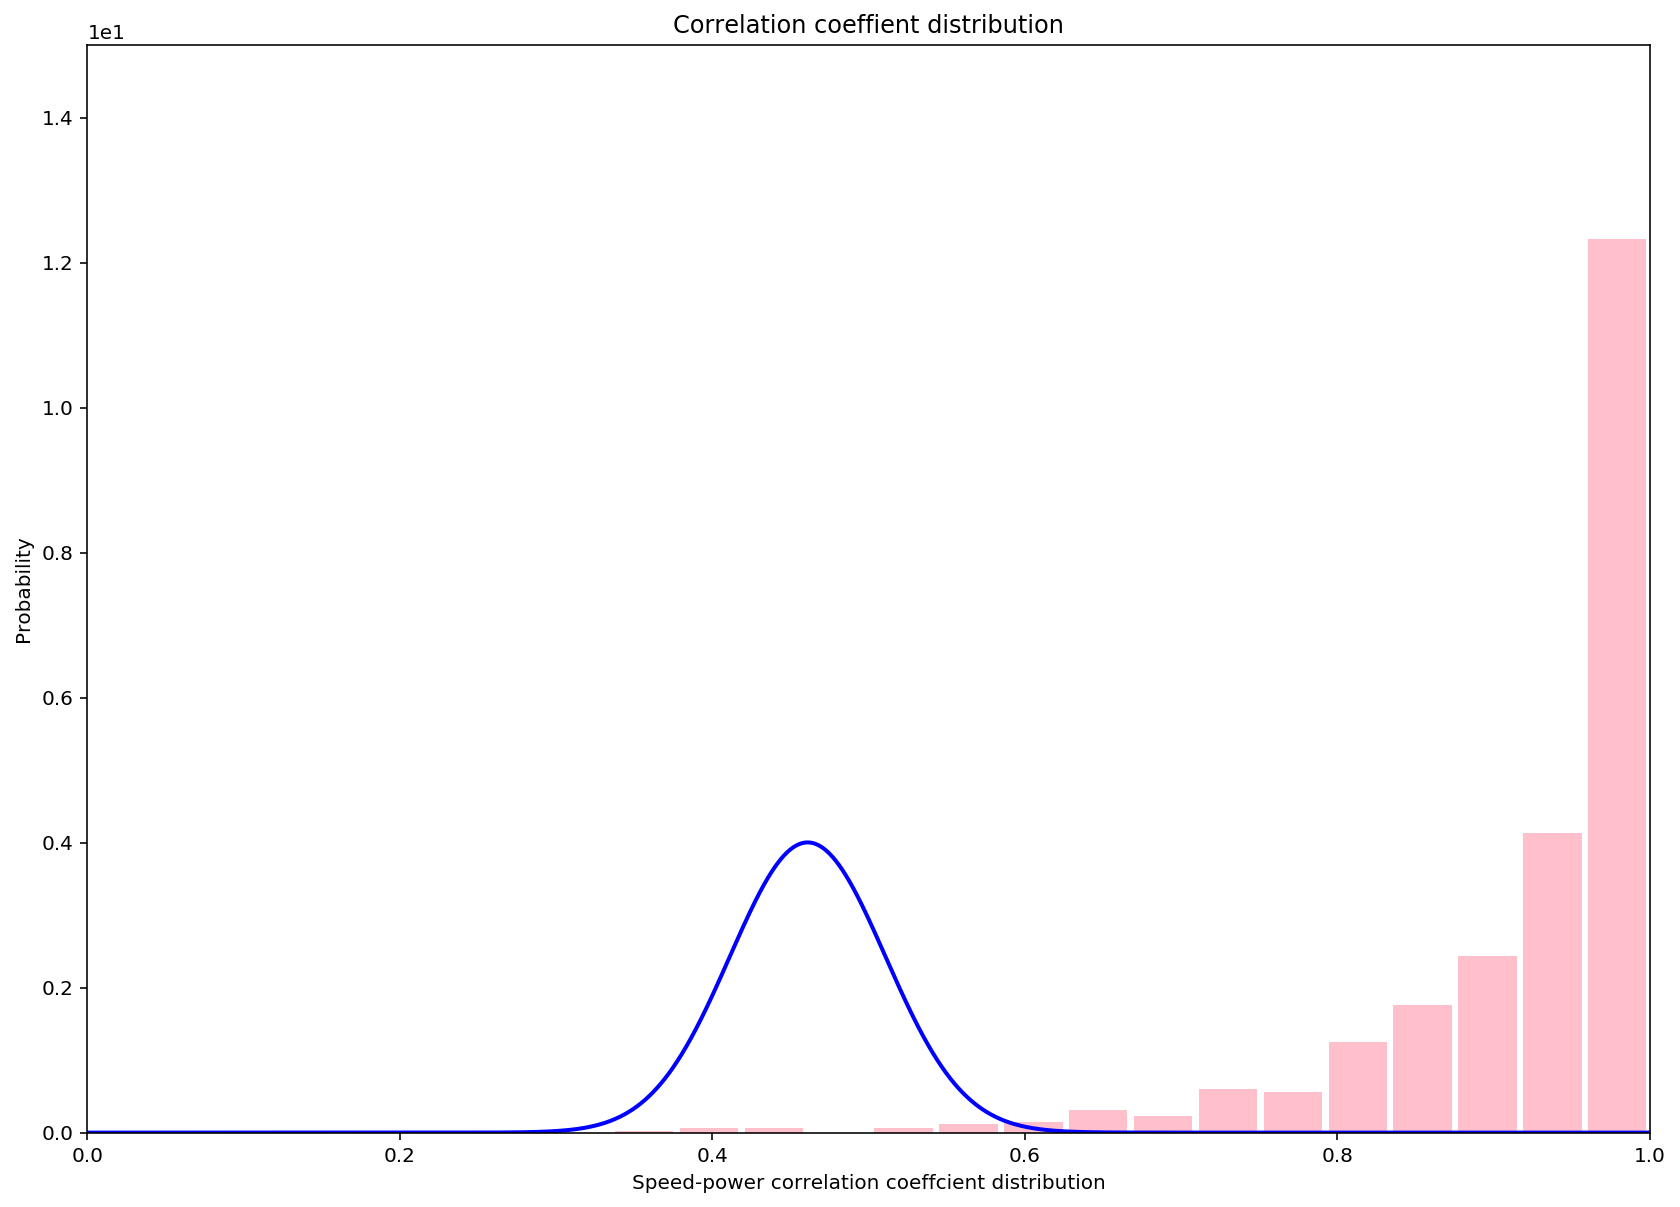

In [16]:
corr_PDF = PDF(PDFx, np.mean(corr_list1), np.std(corr_list1))
print(corr_PDF)
x = np.arange(0, 1, .00025)

plt.figure(figsize = (14, 10))
plt.plot(x, corr_PDF, lw=2, color='b')
plt.hist(corr_list1, normed = True, bins = 20, rwidth = 0.9, color = 'pink')
plt.title('Correlation coeffient distribution')
plt.ticklabel_format(style = 'sci', axis ='y', scilimits = (0,0))
plt.xlabel('Speed-power correlation coeffcient distribution')
plt.ylabel('Probability')
plt.axis([0, 1, 0, 15])

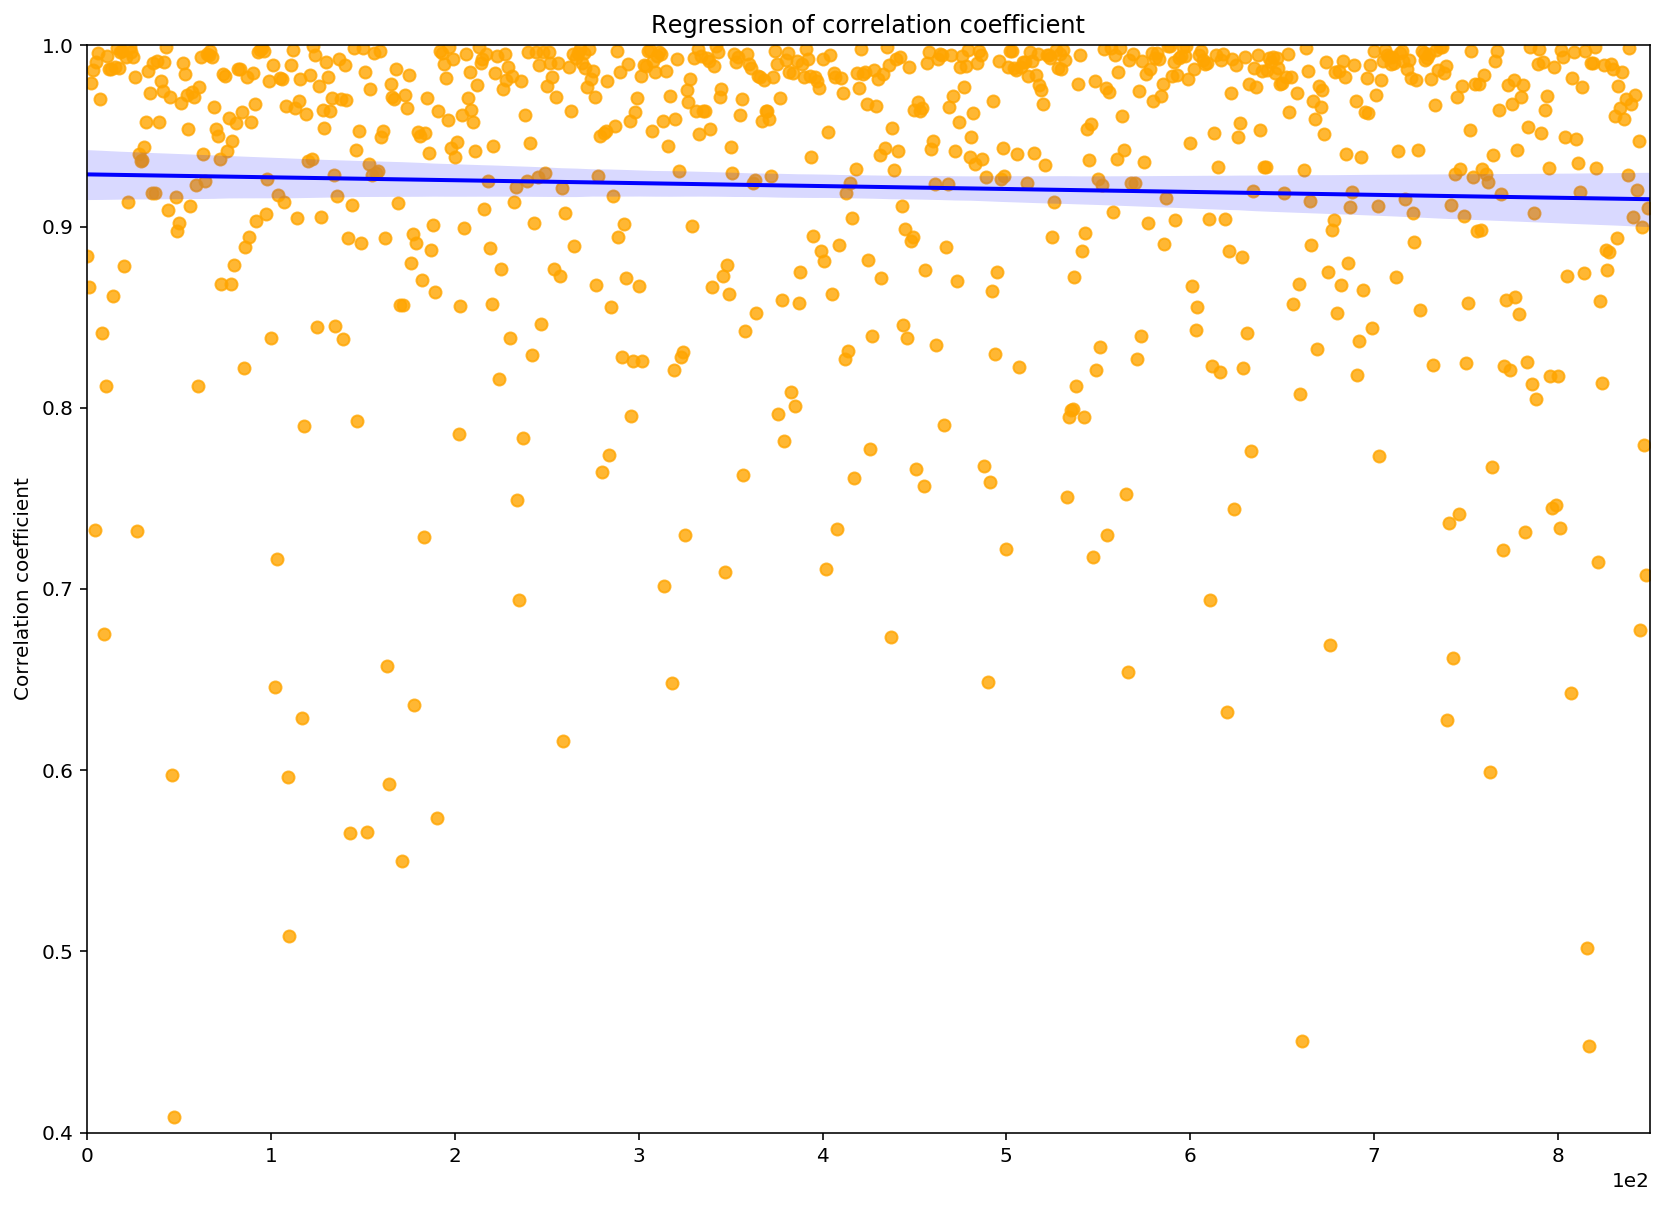

In [17]:
linearreg = skl_lm.LinearRegression()
linearreg.fit(corr_list1, x_corr)
n = linearreg.predict(corr_list1.reshape([-1, 1]))

plt.figure(figsize = (14, 10))
plt.axis([0, 850, 0.4, 1])
plt.ticklabel_format(style = 'sci', axis ='x', scilimits = (0,0))
plt.ylabel('Correlation coefficient')
plt.title('Regression of correlation coefficient')
sns.regplot(x_corr, corr_list1.reshape(-1,), order=1, 
            scatter_kws={'color':'orange'}, line_kws={'color':'b', 'lw':2})

Because the wind power is much related to speed, and wind speed is a natural features we can analyze, so we want to find the discipline of speed value. In oreder to construct the model more accurate we need to calculate the auto-correlation coefficient of power and speed.

In [19]:
power = dt['power (MW)'] .values.reshape([-1, 1])
speed = dt['wind speed at 100m (m/s)'].values.reshape([-1, 1])
direct = dt["wind direction at 100m (deg)"].values.reshape([-1, 1])
tempe = dt["air temperature at 2m (K)"].values.reshape([-1, 1])
densi = dt["surface air pressure (Pa)"].values.reshape([-1, 1])
pres = dt["surface air pressure (Pa)"].values.reshape([-1, 1])
x_reg = np.concatenate([speed, direct, tempe, densi, pres], axis=1)
reg = skl_lm.LinearRegression() 
reg.fit(x_reg, power)

print(reg.coef_)
print(reg.intercept_)

[[  1.91916091e-01   2.73284463e-04  -7.71351188e-03  -3.63484169e-06
   -3.63484169e-06]]
[ 2.39016136]


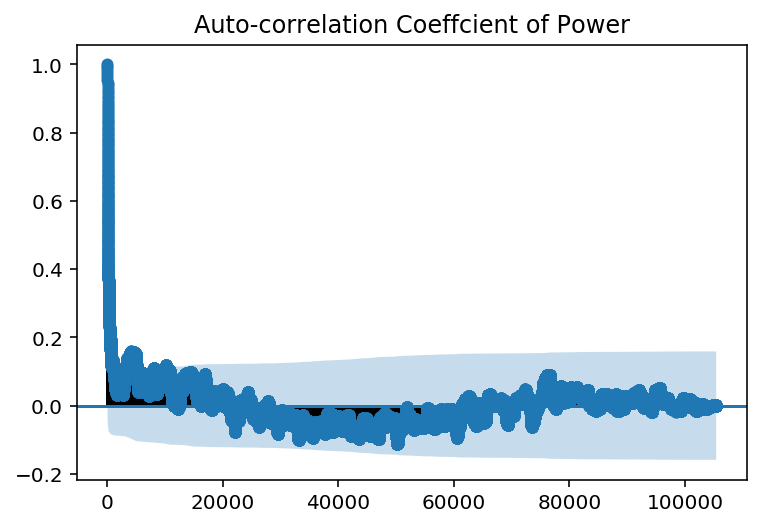

In [57]:
power_series = pd.Series(dt["power (MW)"])

plot_acf(power_series, alpha=0.05)
plt.title('Auto-correlation Coeffcient of Power')

plt.show()

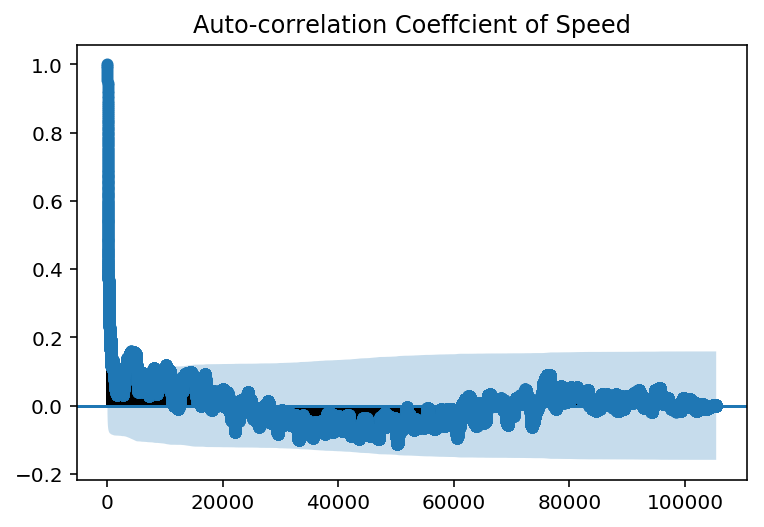

In [58]:
speed_series = pd.Series(dt["wind speed at 100m (m/s)"])

plot_acf(power_series, alpha=0.05)
plt.title('Auto-correlation Coeffcient of Speed')

plt.show()

Here we see the auto-correlation coefficient is much far away from 1.0 and concentrates around '0'. Which means we need a more complicated and intereactive model to make prediction. Hence we further choose the tensorflow to build our re-current neural networks.